# Susceptible, Infected, Recovered: Influenza in a Boarding School

In 1978, anonymous authors sent a note to the British Medical Journal
reporting an influenza outbreak in a boarding school in the north of
England (@bmj-influenza). The chart below shows the solution of the
SIR (Susceptible, Infected, Record) model with parameters which give
roughly the results observed in the school.

We can model this using the [textbook
model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) which
is more or less the one that @1927RSPSA.115 published almost 100 years
ago and which treats the number of infected individuals as continuous.

The Susceptible / Infected / Recovered (SIR) model has three
parameters: one describing how infectious the pathogen is ($\beta$), one
describing how much contact a host has with other hosts ($c$) and one
describing how quickly a host recovers ($\gamma$).

$$
\begin{aligned}
\frac{d S}{d t} &=-c \beta S \frac{I}{N} \\
\frac{d I}{d t} &=c \beta S \frac{I}{N}-\gamma I \\
\frac{d R}{d t} &=\gamma I
\end{aligned}
$$

The infectivity rate and the contact rate are always used as $c\beta$
and are thus non-identifiable so we can replace this product with a
single parameter $\alpha = c\beta$).

$$
\begin{aligned}
\frac{d S}{d t} &=-\alpha S \frac{I}{N} \\
\frac{d I}{d t} &=\alpha S \frac{I}{N}-\gamma I \\
\frac{d R}{d t} &=\gamma I
\end{aligned}
$$

In order to estimate these parameters, we can assume that they come
from prior distribution suggested by the literature and ideally then
use a standard Markov Chain Monte Carlo (MCMC) technique to sample
from the posterior. But with an Agent-Based Model (ABM), the
likelihood is almost always intractable. We thus approximate the
likelihood using particle filtering. The samples for the parameters
that arise in this way are then drawn from the posterior and not just
an approximation to the posterior.

In a nutshell, we draw the parameters from a proposal distribution and
then run the particle filter to calculate the likelihood and compare
likelihoods as in standard MCMC in order to run the chain.

Preliminary results have given a very good fit against observed data
of an influenza outbreak in a boarding school in the UK.

In [1]:
{-# LANGUAGE ViewPatterns        #-}
{-# LANGUAGE NumDecimals         #-}
{-# LANGUAGE OverloadedLists     #-}
{-# LANGUAGE FlexibleContexts    #-}
{-# LANGUAGE RecordWildCards     #-}
{-# LANGUAGE ScopedTypeVariables #-}

import           Numeric.Sundials
import           Numeric.LinearAlgebra hiding ((<>))
import qualified Data.Vector.Storable as VS
import           Control.Monad.Bayes.Class
import qualified Data.Vector as V
import           Control.Exception
import           Control.Monad.IO.Class
import           Katip
import           Katip.Monadic ()
import           System.IO
import qualified Data.Text as T
import qualified Data.Random as R

:l Plotting.hs

In [2]:
{-# LANGUAGE ViewPatterns        #-}
{-# LANGUAGE NumDecimals         #-}
{-# LANGUAGE OverloadedLists     #-}
{-# LANGUAGE FlexibleContexts    #-}
{-# LANGUAGE RecordWildCards     #-}

import           Numeric.Sundials
import           Numeric.LinearAlgebra hiding ((<>))
import qualified Data.Vector.Storable as VS
import           Control.Monad.Bayes.Class
import qualified Data.Vector as V
import           Control.Exception
import           Control.Monad.IO.Class
import           Katip
import           Katip.Monadic ()
import           System.IO
import qualified Data.Text as T

:l Plotting.hs

In [3]:
data SirState = SirState {
    sirStateS :: Double
  , sirStateI :: Double
  , sirStateR :: Double
  } deriving (Eq, Show)

data SirParams = SirParams {
    sirParamsBeta  :: Double
  , sirParamsC     :: Double
  , sirParamsGamma :: Double
  } deriving (Eq, Show)

data SirParams' = SirParams' {
    sirParamsR0    :: Double
  , sirParamsKappa :: Double
  } deriving (Eq, Show)

data Sir = Sir {
    sirS     :: SirState
  , sirP     :: SirParams
  } deriving (Eq, Show)

data SirReparam = SirReparam {
    sirS'     :: SirState
  , sirP'     :: SirParams'
  } deriving (Eq, Show)


As in most languages, it's easy enough to define the actual ODE
problem itself and then run a solver to return the results and then
plot them. Here we are using a 4-th order implicit method from the
[SUNDIALS ODE solver
package](https://sundials.readthedocs.io/en/latest/arkode/Butcher_link.html#sdirk-5-3-4)
but almost any solver would have worked for the set of equations we
using as our example.

I have hidden the details which can made be visible if the reader is
interested.

In [4]:
defaultOpts :: OdeMethod -> ODEOpts
defaultOpts method = ODEOpts
  { maxNumSteps = 1e5
  , minStep     = 1.0e-14
  , fixedStep   = 0
  , maxFail     = 10
  , odeMethod   = method
  , initStep    = Nothing
  , jacobianRepr = DenseJacobian
  }

emptyOdeProblem :: OdeProblem
emptyOdeProblem = OdeProblem
      { odeRhs = error "emptyOdeProblem: no odeRhs provided"
      , odeJacobian = Nothing
      , odeInitCond = error "emptyOdeProblem: no odeInitCond provided"
      , odeEventDirections = V.empty
      , odeEventConditions = eventConditionsPure V.empty
      , odeTimeBasedEvents = TimeEventSpec $ return $ 1.0 / 0.0
      , odeEventHandler = nilEventHandler
      , odeMaxEvents = 100
      , odeSolTimes = error "emptyOdeProblem: no odeSolTimes provided"
      , odeTolerances = defaultTolerances
      }

nilEventHandler :: EventHandler
nilEventHandler _ _ _ = throwIO $ ErrorCall "nilEventHandler"

defaultTolerances :: Tolerances
defaultTolerances = Tolerances
  { absTolerances = Left 1.0e-6
  , relTolerance = 1.0e-10
  }

In [5]:
sir :: Vector Double -> Sir -> OdeProblem
sir ts ps = emptyOdeProblem
  { odeRhs = odeRhsPure f
  , odeJacobian = Nothing
  , odeInitCond = [initS, initI, initR]
  , odeEventHandler = nilEventHandler
  , odeMaxEvents = 0
  , odeSolTimes = ts
  , odeTolerances = defaultTolerances
  }
  where
    f _ (VS.toList -> [s, i, r]) =
      let n = s + i + r in
        [ -beta * c * i / n * s
        , beta * c * i / n * s - gamma * i
        , gamma * i
        ]
    f _ _ = error "Incorrect number of parameters"

    beta  = realToFrac (sirParamsBeta  $ sirP ps)
    c     = realToFrac (sirParamsC     $ sirP ps)
    gamma = realToFrac (sirParamsGamma $ sirP ps)
    initS = realToFrac (sirStateS $ sirS ps)
    initI = realToFrac (sirStateI $ sirS ps)
    initR = realToFrac (sirStateR $ sirS ps)

In [6]:
:i OdeRhs

type OdeRhs :: *
data OdeRhs = OdeRhsHaskell (Foreign.C.Types.CDouble -> Vector Foreign.C.Types.CDouble -> IO (Vector Foreign.C.Types.CDouble)) | OdeRhsC (GHC.Ptr.FunPtr OdeRhsCType) (GHC.Ptr.Ptr UserData)
  	-- Defined in ‘hmatrix-sundials-0.20.0.0:Numeric.Sundials.Common’

In [7]:
us :: [Double]
us = map fromIntegral [1 .. length actuals]

actuals :: [Double]
actuals = [1, 3, 8, 28, 76, 222, 293, 257, 237, 192, 126, 70, 28, 12, 5]

In [8]:
solK :: (MonadIO m, Katip m) =>
        (a -> b -> OdeProblem) -> b -> a -> m (Matrix Double)
solK s ps ts = do
  x <- solve (defaultOpts $ ARKMethod SDIRK_5_3_4) (s ts ps)
  case x of
    Left e  -> error $ show e
    Right y -> return (solutionMatrix y)

testSolK :: (MonadIO m, KatipContext m) => m [Double]
testSolK = do
  m <- solK sir (Sir (SirState 762 1 0) (SirParams 0.2 10.0 0.5)) (vector us)
  let n = tr m
  return $ toList (n!1)

In [9]:
myBracketFormat :: LogItem a => ItemFormatter a
myBracketFormat _withColor _verb Item {..} =
    unLogStr _itemMessage

In [10]:
main :: IO [Double]
main = do
  handleScribe <- mkHandleScribeWithFormatter myBracketFormat ColorIfTerminal stderr (permitItem DebugS) V2
  logEnv <- registerScribe "stderr" handleScribe defaultScribeSettings =<< initLogEnv "test" "devel"
  runKatipContextT logEnv (mempty :: LogContexts) mempty testSolK

In [11]:
main :: IO [Double]
main = do
  handleScribe <- mkHandleScribeWithFormatter myBracketFormat ColorIfTerminal stderr (permitItem DebugS) V2
  logEnv <- registerScribe "stderr" handleScribe defaultScribeSettings =<< initLogEnv "test" "devel"
  runKatipContextT logEnv (mempty :: LogContexts) mempty testSolK

In [12]:
:i Plottable

type Plottable :: * -> Constraint
class Plottable a where
  plotVega :: a -> VegaLiteLab
  {-# MINIMAL plotVega #-}
  	-- Defined at Plotting.hs:60:1
instance Plottable [((Double, Double), T.Text)] -- Defined at Plotting.hs:63:10
instance Plottable [((Double, Double), Double)] -- Defined at Plotting.hs:70:10
instance Plottable [(T.Text, Double)] -- Defined at Plotting.hs:97:10
instance Plottable ([Double], (Double, Double)) -- Defined at Plotting.hs:78:10

Here's the results of running the solver with $R_0 = 4.0, \kappa =0.5$
and with $R_0 = 3.2, \kappa = 0.55$, the former an educated guess and
the latter as a result of running the inference method which is the
main subject of this blog post.

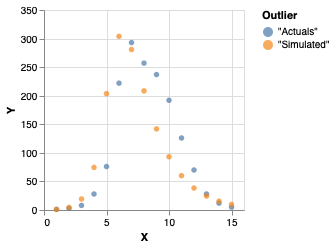

In [13]:
xs <- main

f :: Int -> Double
f = fromIntegral

plotVega 
  (zip (zip (map f ([1..15] <> [1..15])) (actuals <> xs))
       (replicate 15 (T.pack "Actuals") <> replicate 15 (T.pack "Simulated")))

In [14]:
main

[1.0,4.449470258029982,19.260613955067594,74.56001407651216,203.53132707275714,303.9377394431499,280.8355064841971,208.44313889488538,141.93376055400773,93.16867111576789,60.098401961236064,38.41317069995869,24.42723523310017,15.487105777221927,9.80136250623264]

If $\beta$ were constant, then $R_0 := \beta / \gamma$ would
also be constant: the famous *basic reproduction number* for the SIR
model.

When the transmission rate is time-varying, then $R_0(t)$ is a
time-varying version of the basic reproduction number.

Prior to solving the model directly, we make a few changes:

- Re-parameterize using $\beta(t) = \gamma R_0(t)$
- Define the proportion of individuals in each state as $ s := S/N $ etc.
- Divide each equation by $ N $, and write the system of ODEs in terms of the proportions

$$
\begin{aligned}
     \frac{d s}{d t}  & = - \gamma \, R_0 \, s \,  i
     \\
     \frac{d e}{d t}   & = \gamma \, R_0 \, s \,  i  - \gamma i
     \\
      \frac{d r}{d t}  & = \gamma  i
\end{aligned}
$$

In [15]:
sirReparam :: Vector Double -> SirReparam -> OdeProblem
sirReparam ts ps = emptyOdeProblem
  { odeRhs = odeRhsPure f
  , odeJacobian = Nothing
  , odeInitCond = [initS, initI, initR]
  , odeEventHandler = nilEventHandler
  , odeMaxEvents = 0
  , odeSolTimes = ts
  , odeTolerances = defaultTolerances
  }
  where
    f _ (VS.toList -> [s, i, r]) =
      let n = s + i + r in
        [ -kappa * r0 * i / n * s
        , kappa * r0 * i / n * s - kappa * i
        , kappa * i
        ]
    f _ _ = error "Incorrect number of parameters"

    r0 = realToFrac (sirParamsR0  $ sirP' ps)
    kappa = realToFrac (sirParamsKappa $ sirP' ps)
    initS = realToFrac (sirStateS $ sirS' ps)
    initI = realToFrac (sirStateI $ sirS' ps)
    initR = realToFrac (sirStateR $ sirS' ps)

In [16]:
solK' :: (MonadIO m, Katip m) =>
        (a -> b -> OdeProblem) -> b -> a -> m (Matrix Double)
solK' s ps ts = do
  x <- solve (defaultOpts $ ARKMethod SDIRK_5_3_4) (s ts ps)
  case x of
    Left e  -> error $ show e
    Right y -> return (solutionMatrix y)

testSolK' :: (MonadIO m, KatipContext m) => m [Double]
testSolK' = do
  m <- solK' sirReparam (SirReparam (SirState 762 1 0) (SirParams' 4.0 0.5)) (vector us)
  let n = tr m
  return $ toList (n!1)

testSolK'' :: (MonadIO m, KatipContext m) => m [Double]
testSolK'' = do
  m <- solK' sirReparam (SirReparam (SirState 762 1 0) (SirParams' 3.2 0.55)) (vector us)
  let n = tr m
  return $ toList (n!1)

In [17]:
main1 :: IO [Double]
main1 = do
  handleScribe <- mkHandleScribeWithFormatter myBracketFormat ColorIfTerminal stderr (permitItem DebugS) V2
  logEnv <- registerScribe "stderr" handleScribe defaultScribeSettings =<< initLogEnv "test" "devel"
  runKatipContextT logEnv (mempty :: LogContexts) mempty testSolK'

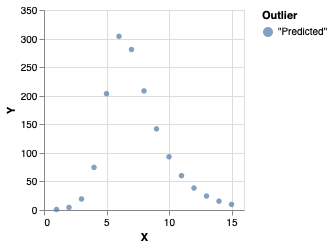

In [18]:
xs <- main1

plotVega 
  (zip (zip (map f ([1..15])) (xs))
       (replicate 15 (T.pack "Predicted")))

We see that e.g. on day 10 our model predicts 93 students in the sick bay
while in fact there are 192 students there. What we would like to do
is to use the last observation to inform our prediction. First we have
to generalise our model so that it can be influenced by the data by
allowing the state to be a general distribution rather than a
particular value. Once we have done this, we can, using particle
filtering, approximate the conditional probability measure of the
state given the observations prior to the state we wish to
estimate. How this is done more precisely is given in the section
"Whatever".

So here is the generalised model where we add noise to the
state. N.B. the invariant that the sum of the susceptible, infected
and recovered remains constant no longer holds.

## System of Stochastic Differential Equations

We switch to a Stochastic Differential Equation (SDE) notation but without the stochasticity to start with.

$$
\begin{aligned}
     d s  & = - \gamma \, R_0 \, s \,  i \, dt
     \\
      d i  & = \left(\gamma \, R_0 \, s \,  i  - \gamma  \, i \right) dt
     \\
     d r  & = \gamma  \, i \, dt
     \\
\end{aligned}
$$

The system can be written in vector form $x := [s, i, r, R_\theta]$ with parameter tuple parameter tuple $p := (\gamma, \eta, \sigma, \bar{R}_0)$

The general form of the SDE is.

$$
\begin{aligned}
d x_t &= F(x_t,t;p)dt + G(x_t,t;p) dW_t
\end{aligned}
$$

With the drift,

$$
F(x,t;p) := \begin{bmatrix}
    -\gamma \, R_0 \, s \,  i
    \\
    \gamma \, R_0 \,  s \,  i  - \gamma i
    \\
    \gamma i
    \\
    \eta (\bar{R}_0 - R_0)
    \\
\end{bmatrix}
$$

Here, it is convenient but not necessary for $ dW_t $ to have the same dimension as $ x $.  If so, then we can use a square matrix $ G(x,t;p) $ to associate the shocks with the appropriate $ x $ (e.g. diagonal noise, or using a covariance matrix).

As the source of Brownian motion only affects the $ d R_0 $ term (i.e. the 4th equation), we define the covariance matrix as

$$
\begin{aligned}
G(x,t;p) &:= \begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & \sigma \sqrt{R_0}
\end{bmatrix}
\end{aligned}
$$

In [19]:
pf :: forall m g a b . (R.StatefulGen g m,
                          MonadReader g m) =>
      Particles a ->
      (a -> m a) ->
      (a -> m b) ->
      (b -> b -> Double) ->
      Particles Double ->
      b ->
      m (Particles b, Particles Double, Double, Particles a)
pf statePrev ff g dd log_w y = do

  let bigN = length log_w
      wn   = map exp $
             zipWith (-) log_w (replicate bigN (maximum log_w))
      swn  = sum wn
      wn'  = map (/ swn) wn

  b <- resampleStratified wn'
  let a              = map (\i -> i - 1) b
      stateResampled = map (\i -> statePrev!!(a!!i)) [0 .. bigN - 1]

  statePredicted <- mapM ff stateResampled
  obsPredicted <- mapM g statePredicted

  let ds                   = map (dd y) obsPredicted
      maxWeight            = maximum ds
      wm                   = map exp $
                             zipWith (-) ds (replicate bigN maxWeight)
      swm                  = sum wm
      predictiveLikelihood =   maxWeight
                             + log swm
                             - log (fromIntegral bigN)

  return (obsPredicted, ds, predictiveLikelihood, statePredicted)

: 

Definition: Let $\mathcal{C}$ be a category. A monad on $\mathcal{C}$ is a triple

$$
\left(C \stackrel{T}{\longrightarrow} C, T^{2} \stackrel{\mu}{\Longrightarrow} T, I \stackrel{\eta}{\Longrightarrow} T\right)
$$

obeying the standard associativity and identity properties.

${\mathcal{C}}_0$ measurable spaces ${\mathcal{C}}_1$ measurable functions on the former

Objects of ${\mathcal{C}}$ and morphisms

$$
P : (X, \Sigma_X) \longrightarrow (PX, \Sigma_{PX})
$$

$$
\begin{array}{ll}
P X \stackrel{ev_{E}}{\longrightarrow}[0,1] & \text { are measurable } \\
\mu \longmapsto \mu(E) & \forall E \in \sum_{X}
\end{array}
$$

$\Sigma_{PX}$ is the smallest $\sigma$-algebra that makes the evaluation map $ev_E$ measurable.

$$
\begin{aligned}
\left(X, \Sigma_{X}\right) \stackrel{f}{\longrightarrow}\left(Y, \Sigma_{r}\right) & \\
P X \stackrel{P f}{\longrightarrow} P Y \quad(P f)(\mu)=f_{*} \mu \\
\left(f_{* \mu}\right)(A)=\mu\left(f^{-1}(A)\right)
\end{aligned}
$$

Monad on measurable spaces aka the Giry Monad

$$
\left(C \stackrel{T}{\longrightarrow} C, T^{2} \stackrel{\mu}{\Longrightarrow} T, I \stackrel{\eta}{\Longrightarrow} T\right)
$$

The Kleisli categany associated with $(T, \mu, \eta)$ has objets the same as $C$

while a morphism from $a$ to $b$ denoted $a \stackrel{f}\rightsquigarrow b$, is defined to be a morphism $a \stackrel{f}{\longrightarrow} T b$.

$$
T_{c} \stackrel{B_{c}}{\longleftarrow} T_{c}^{2} \stackrel{T_{g}}{\longleftarrow} T_{\hookleftarrow} \stackrel{\&}{\longleftarrow}
$$

$C \stackrel{1_C}\rightsquigarrow C$ is $C \stackrel{\eta_C}\rightarrow TC$ 

${\mathcal{C}} \longrightarrow \mathrm{Kl}(T)$

Giry monad has the Kleisli category of measurable spaces and Markov kernels

Example: let $X = \{0, 1, \ldots, n - 1\}$

$PX = \{(p_0, p_1, \ldots, p_{n-1}) \in \mathbb{R}^n \mid p_j \ge 0 \forall j \& \sum_j p_j =1 \}$ in other words a $n - 1$-simplex.

Recall the $\sigma$-algebra on the space $PX$ is defined as the one which makes the evaluation maps measurable.